In [1]:

!pip install torch torchvision matplotlib pillow numpy h5py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import h5py
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:

drive.mount('/content/drive')

face_regions = ['forehead', 'cheeks', 'nose', 'chin']

Mounted at /content/drive


In [14]:
class AcneRegionClassifier(nn.Module):
    def __init__(self):
        super(AcneRegionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, len(face_regions))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [15]:
class AcneDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.webp'))]
        self.labels = self._load_labels()

    def _load_labels(self):
        labels = {}
        for img_file in self.images:
            base_name = os.path.splitext(img_file)[0]
            label_file = os.path.join(self.label_dir, base_name + '.txt')

            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    if lines:
                        parts = lines[0].strip().split()
                        y_center = float(parts[2])
                        if y_center < 0.25:
                            region = 0
                        elif y_center < 0.5:
                            region = 1
                        elif y_center < 0.75:
                            region = 2
                        else:
                            region = 3
                        labels[img_file] = region
                    else:
                        labels[img_file] = 0
            else:
                labels[img_file] = 0
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[img_name]
        return image, label


In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/best_acne_model.pt')
            print(f"Best model saved to /content/best_acne_model.pt")


In [17]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/best_acne_model.pt')
            print(f"Best model saved to /content/best_acne_model.pt")

    torch.save(model.state_dict(), '/content/final_acne_model.pt')
    print(f"Final model saved to /content/final_acne_model.pt")

In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = AcneDataset('/content/drive/MyDrive/data-2/train/images',
                            '/content/drive/MyDrive/data-2/train/labels',
                            transform=transform)
val_dataset = AcneDataset('/content/drive/MyDrive/data-2/valid/images',
                          '/content/drive/MyDrive/data-2/valid/labels',
                          transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, and optimizer
model = AcneRegionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_model(model, train_loader, val_loader, criterion, optimizer)

# Load the best model for testing
loaded_model = AcneRegionClassifier()
loaded_model.load_state_dict(torch.load('/content/best_acne_model.pt'))
loaded_model.to('cuda')

Epoch 1/20, Train Loss: 1.3139, Val Loss: 1.2254
Best model saved to /content/best_acne_model.pt
Epoch 2/20, Train Loss: 1.3009, Val Loss: 1.2079
Best model saved to /content/best_acne_model.pt
Epoch 3/20, Train Loss: 1.2779, Val Loss: 1.2067
Best model saved to /content/best_acne_model.pt
Epoch 4/20, Train Loss: 1.2537, Val Loss: 1.1779
Best model saved to /content/best_acne_model.pt
Epoch 5/20, Train Loss: 1.2623, Val Loss: 1.1575
Best model saved to /content/best_acne_model.pt
Epoch 6/20, Train Loss: 1.2171, Val Loss: 1.1749
Epoch 7/20, Train Loss: 1.1672, Val Loss: 1.1611
Epoch 8/20, Train Loss: 1.1078, Val Loss: 1.1767
Epoch 9/20, Train Loss: 1.0190, Val Loss: 1.2019
Epoch 10/20, Train Loss: 0.9097, Val Loss: 1.2981
Epoch 11/20, Train Loss: 0.7392, Val Loss: 1.5357
Epoch 12/20, Train Loss: 0.5965, Val Loss: 1.5208
Epoch 13/20, Train Loss: 0.4929, Val Loss: 2.2934
Epoch 14/20, Train Loss: 0.4057, Val Loss: 2.0059
Epoch 15/20, Train Loss: 0.3307, Val Loss: 2.4900
Epoch 16/20, Train 

<ipython-input-11-75d819786ed9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/best_acne_model.pt'))


AcneRegionClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (relu): ReLU()
)

In [23]:
def process_and_predict(image_path, model_path, device='cuda', threshold=0.5): # Changed model to model_path
    # Import transforms here to make it accessible within the function
    from torchvision import transforms
    from PIL import Image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    original = Image.open(image_path).convert('RGB')
    # Make sure the model is a model instance, not a path
    #if isinstance(model, str): # Removed this check since model_path will always be a string
    model = AcneRegionClassifier()
    # Load the model's state dictionary from the specified path
    model.load_state_dict(torch.load(model_path, map_location=device)) # Load using model_path
    model.to(device)
    model.eval()

    input_image = transform(original).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_image)
        probabilities = torch.softmax(outputs, dim=1)[0]

    predictions = [(face_regions[i], prob.item()) for i, prob in enumerate(probabilities) if prob > threshold]
    predictions.sort(key=lambda x: x[1], reverse=True)

    return original, original, (probabilities.cpu().numpy(), predictions)

<ipython-input-23-96a73187e7a3>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device)) # Load using model_path


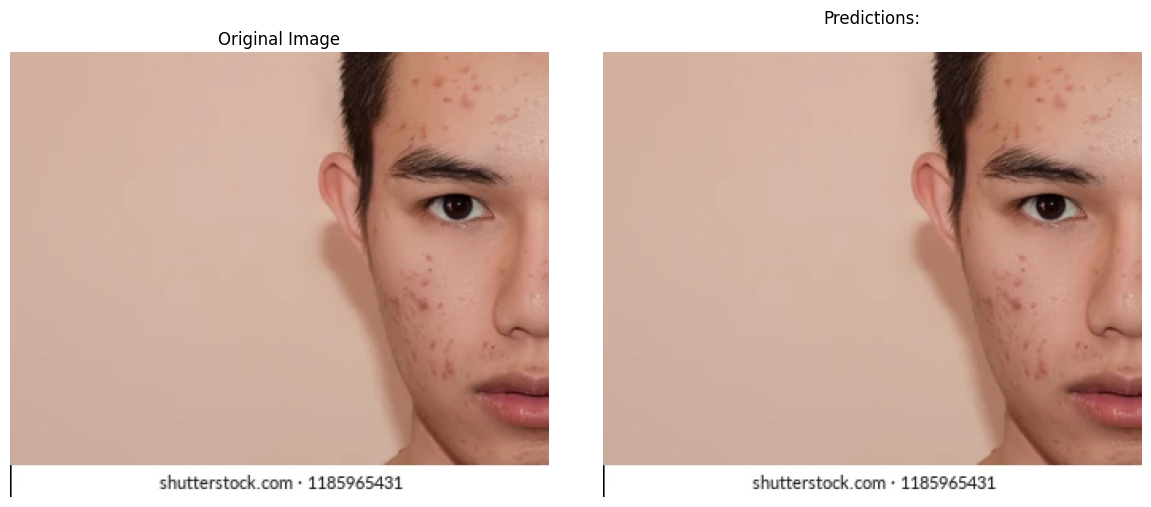

Region with highest likelihood of acne: 0.36127758


In [33]:
image_path = '/content/man.webp'
loaded_model_path = '/content/best_acne_model.pt' # Changed loaded_model to loaded_model_path
original, reconstructed, predictions = process_and_predict(image_path, loaded_model_path) # Pass loaded_model_path here

visualize_results_with_predictions(original, reconstructed, predictions)

print("Region with highest likelihood of acne:", max(predictions[0]))
